## Motivation

Analyzing chromatin accessibility and gene expression together to understand gene regulation is helpful due to the mechanistic relationship between those two during the control of gene regulation, mediated through transcription factors (TFs) and other epigenetic modulators {cite}`Spitz2012-sw`. Briefly, regulatory regions annotated as promoters and local/distal enhancers are engaged during the early phases of gene expression regulation, and chromatin accessibility increase, or decrease, can be used as a proxy for changes in their activity. Hence, the global positive or negative correlation between proximal and distal accessible elements (measured by ATAC-seq) and target genes (measured by RNA-seq) within a genome neighborhood distance (e.g. less than 200 Mbp), serves to annotate genomic regulatory relationships during the inference of Gene Regulatory Networks (GRNs). Using sequencing data describing gene (RNA) and peak (ATAC) features, tools that build correlation matrices between peaks and matrices help summarize strong peak-gene interactions.

### Gene regulatory network inference using RNA and ATAC features

In this notebook, we will use the package **FigR** {cite}`Kartha2022-lp` to describe such GRN-building steps on a donor of the NeurIPs dataset. Preparation scripts of this notebook will also call cisTopic {cite}`Bravo_Gonzalez-Blas2019-zj` to generate peak clusters or **topics** from the ATAC seq counts matrix. During the calculation of RNA-ATAC correlations, FigR uses ChromVAR {cite}`Schep2017-vi` to map Transcription Factor motifs to the mapped peaks. The main processing steps described in this notebook are adapted based on FigR's core tutorial for SHARE-seq data [Tutorial](https://buenrostrolab.github.io/FigR/articles/FigR_shareseq.html)

Disclaimer: At the time of writing this chapter, several methods that utilize single-cell RNA and ATAC information for GRN inference are currently available. Due to similar benchmarking reasons as the one indicated in the previous chapter, we cannot say that these methods will perform best in the majority of scenarios. We globally recommend either of those as a starting point, given available data, to infer preliminary GRNs.


### Install and load FigR package

In [1]:
# the installation of this package is required for the proper execution of this notebook.
if(!require("FigR"))
    devtools::install_github("caleblareau/BuenColors") # the package BuenColors is also a devtools dependency to install FigR.
    devtools::install_github("buenrostrolab/FigR")

Loading required package: FigR

Loading required package: Matrix

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
suppressMessages(library(FigR))

### Use zellkonverter to convert h5ad to SingleCellExperiment

In [4]:
library(zellkonverter)
library(SingleCellExperiment)

Registered S3 method overwritten by 'zellkonverter':
  method                from      
  py_to_r.numpy.ndarray reticulate



Load the full NeurIPs dataset using zellkonverter. Then, subset for one donor (s1d1) using the `batch` column. This donor will be the one used in this tutorial.

In [5]:
sce <- readH5AD("../../data/openproblems_bmmc_multiome_genes_filtered.h5ad")
sce <- sce[colData(sce)$batch == 's1d1',]

For faster computing, we define a subset of features

In [6]:
ncells = -1 # if using all cells
nfeatures_rna = 10000 # -1 if using all rna features
nfeatures_atac = 10000 # -1 if using all atac features

Once donor s1d1 is subset, divide features by RNA and ATAC into two objects
(in case of a new index, it can be checked with `rownames(sce)`)

In [7]:
RNA <- sce[1:13431,]
ATAC <- sce[13432:nrow(sce),]

Download the list of TFs annotations for hg38, using the same gene labels as the RNA-only tutorial. Other annotations, such as [HumanTFs](http://humantfs.ccbr.utoronto.ca/), can also be used.

In [8]:
if(!file.exists('allTFs_hg38.txt'))
    download.file('https://raw.githubusercontent.com/aertslab/SCENICprotocol/master/example/allTFs_hg38.txt', 'allTFs_hg38.txt')
tf_names = rownames(read.table('allTFs_hg38.txt', row.names=1))
print(length(tf_names))

[1] 1797


In [9]:
# subset by cells:
if(ncells != -1){
    RNA <- RNA[,1:ncells]
    ATAC <- ATAC[,1:ncells]
}
if(nfeatures_rna != -1){

    # select all TFs and a subset of non-TFs
    is_tf <- rownames(RNA) %in% tf_names
    index_tf <- which(is_tf)
    index_not_tf <- which(!is_tf)
    set.seed(nfeatures_rna)
    RNA <- RNA[c(index_tf, sample(index_not_tf, nfeatures_rna - length(index_tf))),]
}


Selection of peaks, based on the coefficient of variation criterion, adapted from the [EpiScanpy's implementation](https://episcanpy.readthedocs.io/en/anna/api/episcanpy.pp.select_var_feature.html)

In [10]:
if(nfeatures_atac != -1){
    frac_atac <- rowSums(assay(ATAC)) / ncol(ATAC)
    acc_score <- abs(0.5 - frac_atac)
    peak_mask <- rownames(ATAC) %in% names(sort(acc_score))[1:nfeatures_atac]
    ATAC <- ATAC[peak_mask,]
}


In [11]:
print(c(dim(ATAC), dim(RNA)))
is_tf <- rownames(RNA) %in% tf_names

[1] 10000  6224 10000  6224


In [12]:
UMAP <- reducedDim(ATAC, 'GEX_X_umap')

In [13]:
# counts variable (for later functions)
assay(ATAC) <- as(assay(ATAC), 'sparseMatrix')
counts(ATAC) <- assay(ATAC)

Preprocessing of SummarizedExperimentObject using the number of cells

In [14]:
# Remove genes with zero expression across all cells
# RNA <- RNA[Matrix::rowSums(RNA) != 0,]

### Preparation and execution of cisTopic

cisTopic applies Latent Dirichlet allocation to define a number of "topics" that are able to summarize the variability of the observed chromatin accessibility counts retrieved by ATAC-seq. Here, we install, calculate of the cisTopic object using scATAC-seq, and use it downstream as input for FigR.

Installation of cisTopic through devtools (if required). This installation takes approximately ten minutes, due to cisTopic-specific dependencies.
(restart of kernel might be required)

In [15]:
if(!require("cisTopic"))
    devtools::install_github("aertslab/cisTopic")

Loading required package: cisTopic

Warning message:
“replacing previous import ‘GenomicRanges::shift’ by ‘data.table::shift’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘data.table::last’ by ‘dplyr::last’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘GenomicRanges::union’ by ‘dplyr::union’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘GenomicRanges::intersect’ by ‘dplyr::intersect’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘GenomicRanges::setdiff’ by ‘dplyr::setdiff’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘data.table::first’ by ‘dplyr::first’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘data.table::between’ by ‘dplyr::between’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘dplyr::failwith’ by ‘plyr::failwith’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘dplyr::id’ by ‘plyr::id’ when lo

In [16]:
suppressMessages(library(cisTopic))

The following script requires indicating a number of cores (`nCores`). Increase according to computing resources available

In [17]:
nCores = 2

In [18]:
cistopic_bkp_path <- "../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_cisTopic.rds"
if(nfeatures_atac != -1)
    cistopic_bkp_path <- paste0("../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_cisTopic_npeaks", nfeatures_atac, ".rds")
print(c(file.exists(cistopic_bkp_path), cistopic_bkp_path))

[1] "TRUE"                                                                                          
[2] "../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_cisTopic_npeaks10000.rds"


This analysis through cisTopic generates two visualization of interest:
- The log-likelihood reported by cisTopic, as the number of declared topics is increased. The higher this number is, the more topics are required.
- The first derivative of likelihood versus number of declared topics. This visualization also suggests convergence the likelihood and random oscilations around zero, as the number increases.

In [19]:
if(!file.exists(cistopic_bkp_path)){
    # the number of topics to test
    n_topics = 1:25

    atac <- as.matrix(counts(ATAC))
    atac <- as.data.frame(atac)

    # we need to work out the names of the rownames, and replace - into : to match the chromosome:start-end required format by cisTopic
    chr <- sapply(strsplit(rownames(atac),"-"), `[`, 1)
    start <- sapply(strsplit(rownames(atac),"-"), `[`, 2)
    end <- sapply(strsplit(rownames(atac),"-"), `[`, 3)
    rownames(atac) <- paste0(chr, ':', start, '-', end)

    cisTopicObject <- createcisTopicObject(atac, project.name='neurips_s1d1')
    cisTopicObject <- runCGSModels(cisTopicObject, topic=c(n_topics), # , 5:15, 20, 25), # topic=c(2, 5:15, 20, 25),
                               seed=987, nCores=nCores, burnin = 90,
                               iterations = 100, addModels=FALSE)

    cisTopicObject <- selectModel(cisTopicObject, type='maximum')

    # cisTopicObject
    cisTopicObject <- runUmap(cisTopicObject, target='cell')

    topic.mat <- modelMatSelection(cisTopicObject, 'cell', 'Probability')
    topic.mat <- t(topic.mat)
    topic.mat <- as.matrix(topic.mat)
    saveRDS(topic.mat, cistopic_bkp_path)
}
print('done calculating CisTopic object')

[1] "done calculating CisTopic object"


Once the CisTopic object is generated, we can use it to extract relevant features

In [20]:
cisAssign <- readRDS(cistopic_bkp_path)
dim(cisAssign) # Cells x Topics
# all(cellsToKeep %in% rownames(cisAssign))
# # Subset
# cisAssign <- cisAssign[cellsToKeep,]

[1] 6224   25

Calculate a kNN-graph using the topics matrix from cisTopic

In [21]:
library(dplyr)
library(FNN)

In [22]:
set.seed(123)
cellkNN <- get.knn(cisAssign, k = 30)$nn.index
dim(cellkNN)
# rownames(cellkNN) <- cellsToKeep

[1] 6224   30

Visualization of cells using the embedding generated by UMAP

In [23]:
colData(ATAC)$cellAnnot <- colData(ATAC)$cell_type

In [24]:
colData(ATAC)$UMAP1 <- UMAP[,1]
colData(ATAC)$UMAP2 <- UMAP[,2]

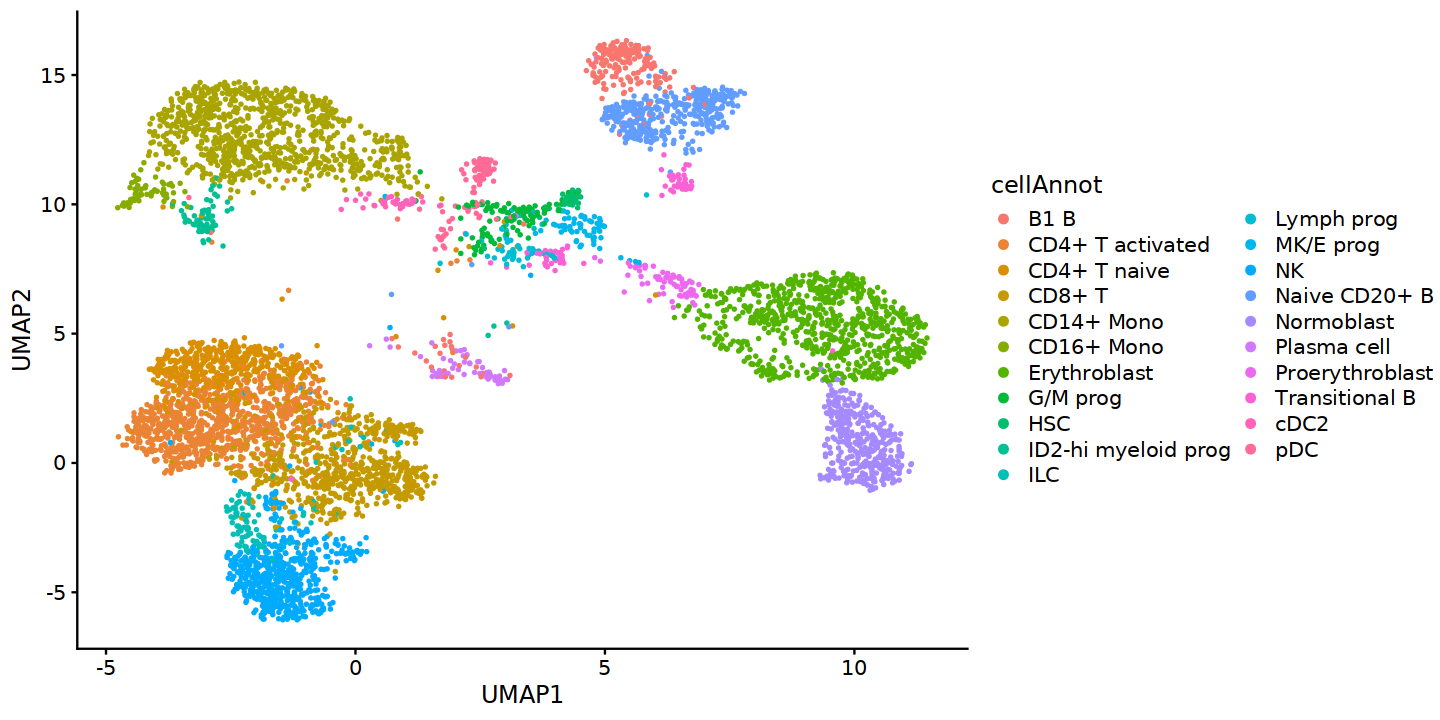

In [25]:
# Plot
library(ggplot2)
options(repr.plot.width=12, repr.plot.height=6)
colData(ATAC) %>% as.data.frame() %>% ggplot(aes(UMAP1,UMAP2,color=cellAnnot)) +
  geom_point(size=0.5) + # scale_color_manual(values=annoCols)+
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=2))) + cowplot::theme_cowplot(font_family='Sans')

Preparation of input data is finished. Now, the execution of the FigR algorithm begins.

In [26]:
# if the hg38 genome is not installed successfully during environment building, it can be installed here.
# this might require a kernel restart
if(!require('BSgenome.Hsapiens.UCSC.hg38')){
    if (!require("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
    BiocManager::install("BSgenome.Hsapiens.UCSC.hg38")
}

Loading required package: BSgenome.Hsapiens.UCSC.hg38

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer



In [27]:
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg38))

In [28]:
# check object dimensions
c(dim(ATAC), dim(RNA))

[1] 10000  6224 10000  6224

The following script requires indicating a number of cores (`nCores`). Increase according to computing resources available

Prepare data for runGenePeakcorr

In [31]:
library(Matrix)
RNAmat <- as.matrix(assay(RNA))
dim(RNAmat)

[1] 10000  6224

In [36]:
ATAC_df <- as.data.frame(as.matrix(counts(ATAC)))
# df <- as.data.frame(as.matrix(counts(ATAC)))

In [37]:
ATAC_df$seqnames <- sapply(strsplit(rownames(ATAC_df),"-"), `[`, 1)
ATAC_df$start <- sapply(strsplit(rownames(ATAC_df),"-"), `[`, 2)
ATAC_df$end <- sapply(strsplit(rownames(ATAC_df),"-"), `[`, 3)

In [38]:
ATAC_df <- subset(ATAC_df, grepl('chr', rownames(ATAC_df)))
dim(ATAC_df)

In [40]:
ATAC.se <- makeSummarizedExperimentFromDataFrame(ATAC_df)
counts(ATAC.se) <- assay(ATAC.se)
assay(ATAC.se) <- as(assay(ATAC.se), 'sparseMatrix')

Run runGenePeakcorr function from FigR using 2 cores

In [41]:
# This snippet can be run interactively, but it takes a long time.
nCores = 2
bkp_path_ciscorr <- '../../data/openproblems_bmmc_multiome_genes_filtered_s1d1_ciscorr.rds'
if(nfeatures_atac != -1)
    cistopic_bkp_path <- paste0("../../data/openproblems_bmmc_multiome_genes_filtered_s1d1_ciscorr_npeaks", nfeatures_atac, ".rds")
print(c(file.exists(bkp_path_ciscorr), cistopic_bkp_path))

if(!file.exists(bkp_path_ciscorr)){
    cisCorr <- FigR::runGenePeakcorr(ATAC.se = ATAC.se,
                               RNAmat = RNAmat,
                               genome = "hg38", # One of hg19, mm10 or hg38
                               nCores = nCores,
                               p.cut = NULL, # Set this to NULL and we can filter later
                               n_bg = 250)
    saveRDS(cisCorr, bkp_path_ciscorr)
}
cisCorr <- readRDS(bkp_path_ciscorr)

[1] "TRUE"                                                                             
[2] "../../data/openproblems_bmmc_multiome_genes_filtered_s1d1_ciscorr_npeaks10000.rds"


Filter relevant peak-gene correlations by p-value

In [43]:
cisCorr.filt <- cisCorr %>% filter(pvalZ <= 0.05)
print(c('all associations', nrow(cisCorr)))
print(c('filtered associations', nrow(cisCorr.filt)))

[1] "all associations" "3914"            
[1] "filtered associations" "674"                  


In [44]:
if(nrow(cisCorr.filt) == 0)
    print('increase the number of cells/peaks/genes to discover more associations')
stopifnot(nrow(cisCorr.filt) > 0)

Once the Peak and Gene correlations have been calculated, FigR groups ATAC-seq peaks into Domains of regulatory chromatin (DORCs). These groups are useful to describe relationships between the expression of TFs RNA levels with the overall change of multiple chromatin-accessible elements around a gene. Importantly, if multiple of those chromatin-accessible elements in a DORC also contain DNA-binding motifs related to the TF of interest, both lines of evidence are useful for broadly describing TF activators (TF motif enrichment and positive DORC - TF RNA correlation) or TF repressors (TF motif enrichment and negative DORC - TF RNA correlation).

The visualization below indicated the ranking of TFs by number of peaks strongly correlated to those, and indirectly provides information about TFs most strongly associated to DORCs.

In [45]:
library(ggrepel)

NULL

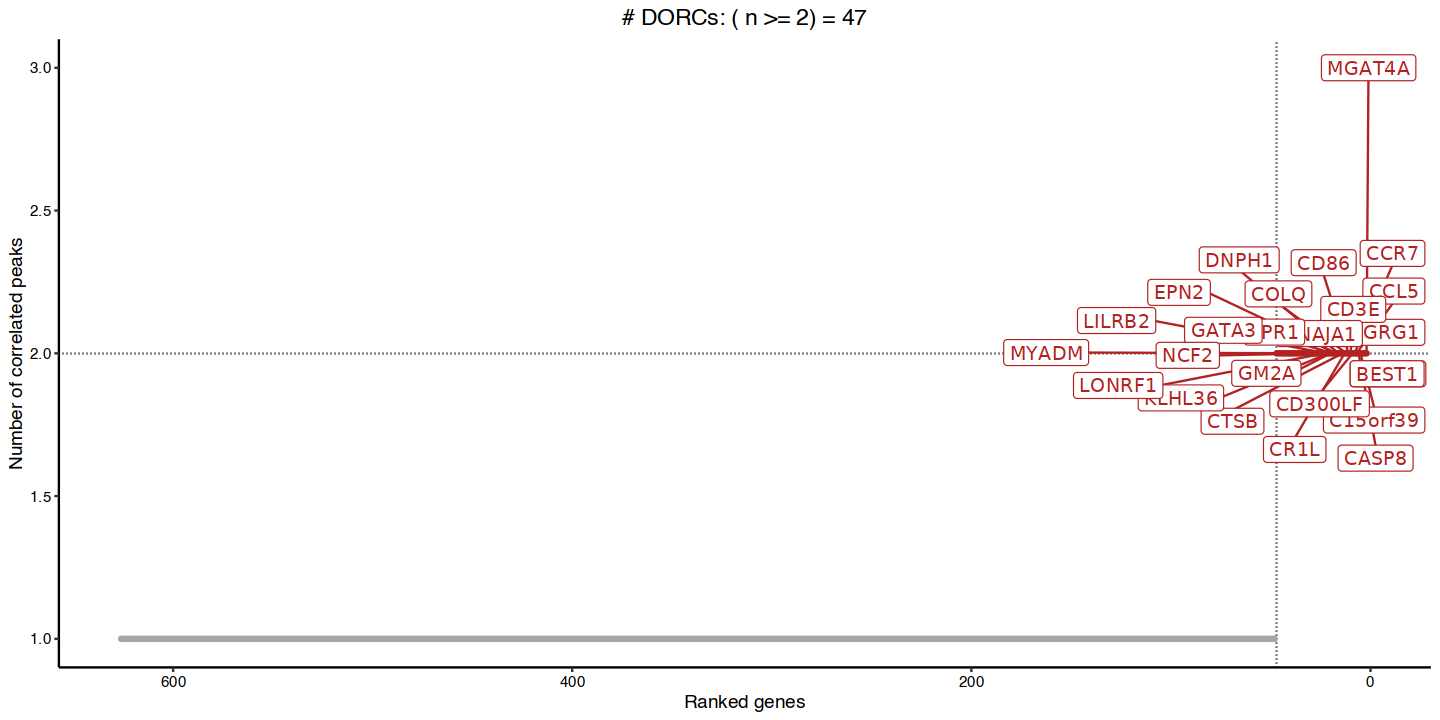

In [46]:
# Determine DORC genes
options(repr.plot.width=12, repr.plot.height=6)
cowplot_mono <- cowplot::theme_cowplot(font_family='sans')
dorcGenes <- cisCorr.filt %>% dorcJPlot(cutoff=2, # Default
                                       returnGeneList = TRUE, family='sans') # + cowplot_mono

theme_set(theme_gray(base_family = "sans"))
dorcGenes + theme(font='roboto') # font problem during visualization of y/x axes (Roboto)

Modify the cutoff here to recover at last 30 genes. Otherwise, the runFigRGRN could not be executed.

In [47]:
stopifnot(length(dorcGenes) > 30)

Get DORC scores

In [48]:
dorcMat <- getDORCScores(ATAC.se, dorcTab=cisCorr.filt, geneList=dorcGenes, nCores=nCores)
# Smooth DORC scores (using cell KNNs)

Running DORC scoring for 47 genes: MGAT4A
ADGRG1
APBB1
BEST1
C15orf39
CASP8
CCL5
CCR7
CD300LF
CD3E
CD86
COLQ
CR1L
CTSB
DNAJA1
DNPH1
EPN2
FPR1
GATA3
GM2A
KLHL36
LILRB2
LONRF1
MYADM
NCF2
NFIA
NOLC1
P2RX1
PRF1
PRKCQ-AS1
PTCH1
RFPL1S
RHOQ
RXRA
SESN3
SLC16A6
SLC2A9
SMAD7
STRN3
SWAP70
TEC
THEMIS
TLE1
TM9SF2
TNRC6B
ZNF471
ZNRF1



........
Normalizing scATAC counts ..
SummarizedExperiment object input detected .. Centering counts under assayCentering counts for cells sequentially in groups of size  5000  ..

Computing centered counts for cells:  1  to  5000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  5001  to  6224 ..
Computing centered counts per cell using mean reads in features ..

Merging results..
Done!
Computing DORC scores ..
Running in parallel using  2 cores ..

Time Elapsed:  0.875501871109009 secs 



In [49]:
stopifnot(nrow(cellkNN) == ncol(dorcMat))

In [50]:
rownames(cellkNN) <- colnames(dorcMat)

To execute the smoothScores NN function with multiple cores, doParallel is required.

In [51]:
library(doParallel)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [52]:
# Smooth dorc scores using cell KNNs (k=30)
dorcMat.s <- smoothScoresNN(NNmat = cellkNN[,1:30], mat = dorcMat, nCores = nCores)

Number of cells in supplied matrix:  6224 
Number of genes in supplied matrix:  47 
Number of nearest neighbors being used per cell for smoothing:  30 
  |                                                                      |   0%Running in parallel using  2 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  13.4404098987579 secs 


In [53]:
stopifnot(nrow(cellkNN) == ncol(RNAmat))

In [54]:
rownames(cellkNN) <- colnames(RNAmat)

In [55]:
# Smooth RNA using cell KNNs
# This takes longer since it's all genes
RNAmat.s <- smoothScoresNN(NNmat = cellkNN[,1:30], mat = RNAmat, nCores = nCores)

Number of cells in supplied matrix:  6224 
Number of genes in supplied matrix:  10000 
Number of nearest neighbors being used per cell for smoothing:  30 
  |                                                                      |   0%Running in parallel using  2 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  1.15682717959086 mins 


In [56]:
library(ggplot2)
library(ggrastr)

In [57]:
# Visualize on pre-computed UMAP
umap.d <- as.data.frame(colData(ATAC)[,c("UMAP1","UMAP2")])

Once the DORC scores are calculated, we can explore associations between TFs and target genes, or the overall expression of TFs in each of cell types. Those two metrics contribute to an understanding of how cell types.

In [58]:
print(length(dorcGenes))
print(dorcGenes)

[1] 47
 [1] "MGAT4A"    "ADGRG1"    "APBB1"     "BEST1"     "C15orf39"  "CASP8"    
 [7] "CCL5"      "CCR7"      "CD300LF"   "CD3E"      "CD86"      "COLQ"     
[13] "CR1L"      "CTSB"      "DNAJA1"    "DNPH1"     "EPN2"      "FPR1"     
[19] "GATA3"     "GM2A"      "KLHL36"    "LILRB2"    "LONRF1"    "MYADM"    
[25] "NCF2"      "NFIA"      "NOLC1"     "P2RX1"     "PRF1"      "PRKCQ-AS1"
[31] "PTCH1"     "RFPL1S"    "RHOQ"      "RXRA"      "SESN3"     "SLC16A6"  
[37] "SLC2A9"    "SMAD7"     "STRN3"     "SWAP70"    "TEC"       "THEMIS"   
[43] "TLE1"      "TM9SF2"    "TNRC6B"    "ZNF471"    "ZNRF1"    


One of the genes with strong correlations with TF expression is [Nuclear Factor I A (NFIA)](http://humantfs.ccbr.utoronto.ca/myTFPageUniversal.php?user=&eID=ENSG00000162599&dbd=&submit_param=submit_value). We can inspect this case further by checking its gene expression levels and dorcGenes linked with its motif on ATAC peaks.

In [59]:
marker_gene = 'NFIA'

In [60]:
dorcg <- plotMarker2D(umap.d,dorcMat.s,markers = c(marker_gene),maxCutoff = "q0.99",
                      colorPalette = "brewer_heat") + ggtitle(paste0(marker_gene, ' DORC'))


Plotting  NFIA 


In [61]:
rnag <- plotMarker2D(umap.d,RNAmat.s,markers = c(marker_gene),maxCutoff = "q0.99",
                     colorPalette = "brewer_purple") + ggtitle(paste0(marker_gene, ' RNA'))

Plotting  NFIA 


Here, we visualize dorcg and rnag objects, using patchwork. This allows visual comparison of gene expression and associated DORC scores, per cell.


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




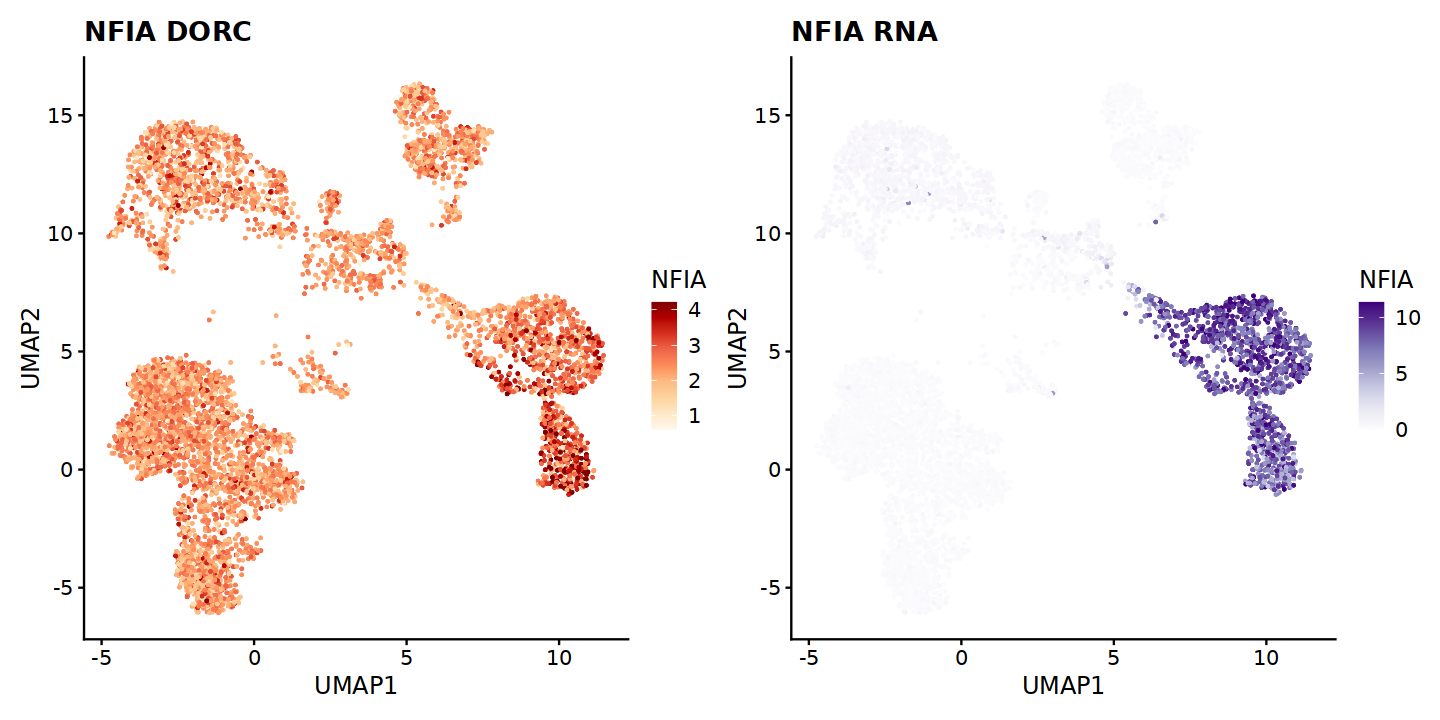

In [62]:
options(repr.plot.width=12, repr.plot.height=6)
library(patchwork)
dorcg + cowplot_mono + rnag + cowplot_mono

Through a visual comparison, we can identify that the agreement between NFIA expression and DORC scores is not 1-to-1, meaning that in some cell type clusters NFIA is strongly expressed, yet there is no strong correlation between those expression levels and ATAC peaks putatively occupied with NFIA.

In [63]:
dim(dorcMat.s)

[1]   47 6224

In [64]:
figR.d <- runFigRGRN(ATAC.se = ATAC.se, # Must be the same input as used in runGenePeakcorr()
                     dorcTab = cisCorr.filt, # Filtered peak-gene associations
                     genome = "hg38",
                     dorcMat = dorcMat.s,
                     rnaMat = RNAmat.s,
                     nCores = nCores)

Assuming peak indices in Peak field

Removing genes with 0 expression across cells ..




Getting peak x motif matches ..
Determining background peaks ..
Using  50  iterations ..

Testing  626  TFs
Testing  47  DORCs


Running FigR using 2 cores ..




  |======================================================================| 100%Finished!
Merging results ..


## Results visualization

TF-DORC regulation scores (scatter plot). The y-axis indicates motif enrichment of a TF in DORCs, whereas the x-axis indicates the correlation between TF expression and those peaks (Z-test versus background). Intuitively, this visualization allows us to retrieve putative TF-activators (upper-right) and TF-repressors (upper-left).

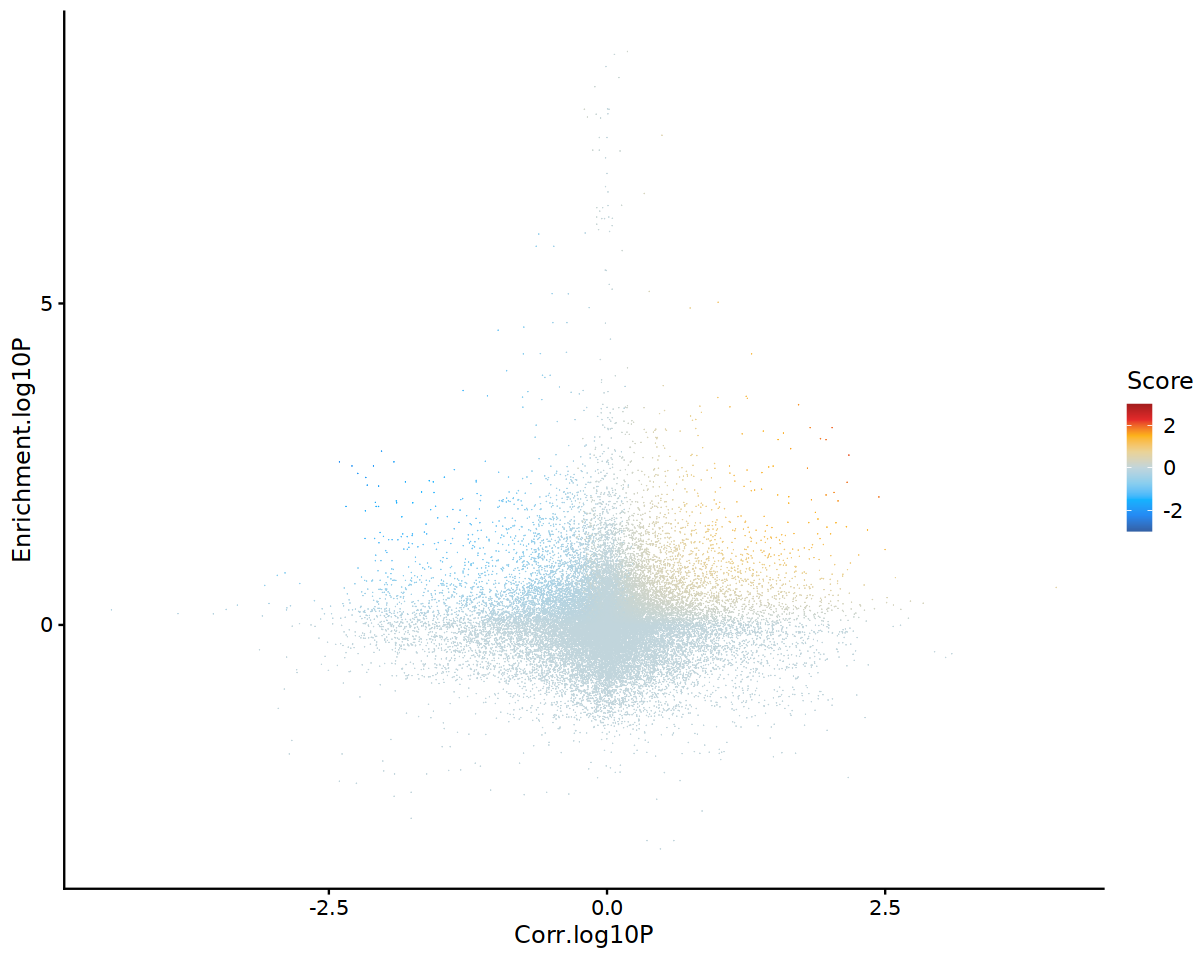

In [84]:
require(ggplot2)
require(ggrastr)
require(BuenColors) # https://github.com/caleblareau/BuenColors

options(repr.plot.width=10, repr.plot.height=8)

figR.d %>%
  ggplot(aes(Corr.log10P,Enrichment.log10P,color=Score)) +
  ggrastr::geom_point_rast(size=0.01,shape=16) +
  theme_classic() +
  scale_color_gradientn(colours = jdb_palette("solar_extra"),limits=c(-3,3),oob = scales::squish,breaks=scales::breaks_pretty(n=3)) +
  cowplot_mono + cowplot::theme_cowplot(font_family='sans' )

Rank based visualization of driver TFs, to get an intuitive positive-negative priority list of relevant TF candidates.

This next visualization attempts to visualize the relevant motifs annotated, by their associated number of target genes activated or repressed. This allows to observe the coverage of top-motifs potentially activating or repressing certain gene programs in the studied sample.


Ranking TFs by total number of associated DORCs ..


Using absolute score cut-off of: 1 ..




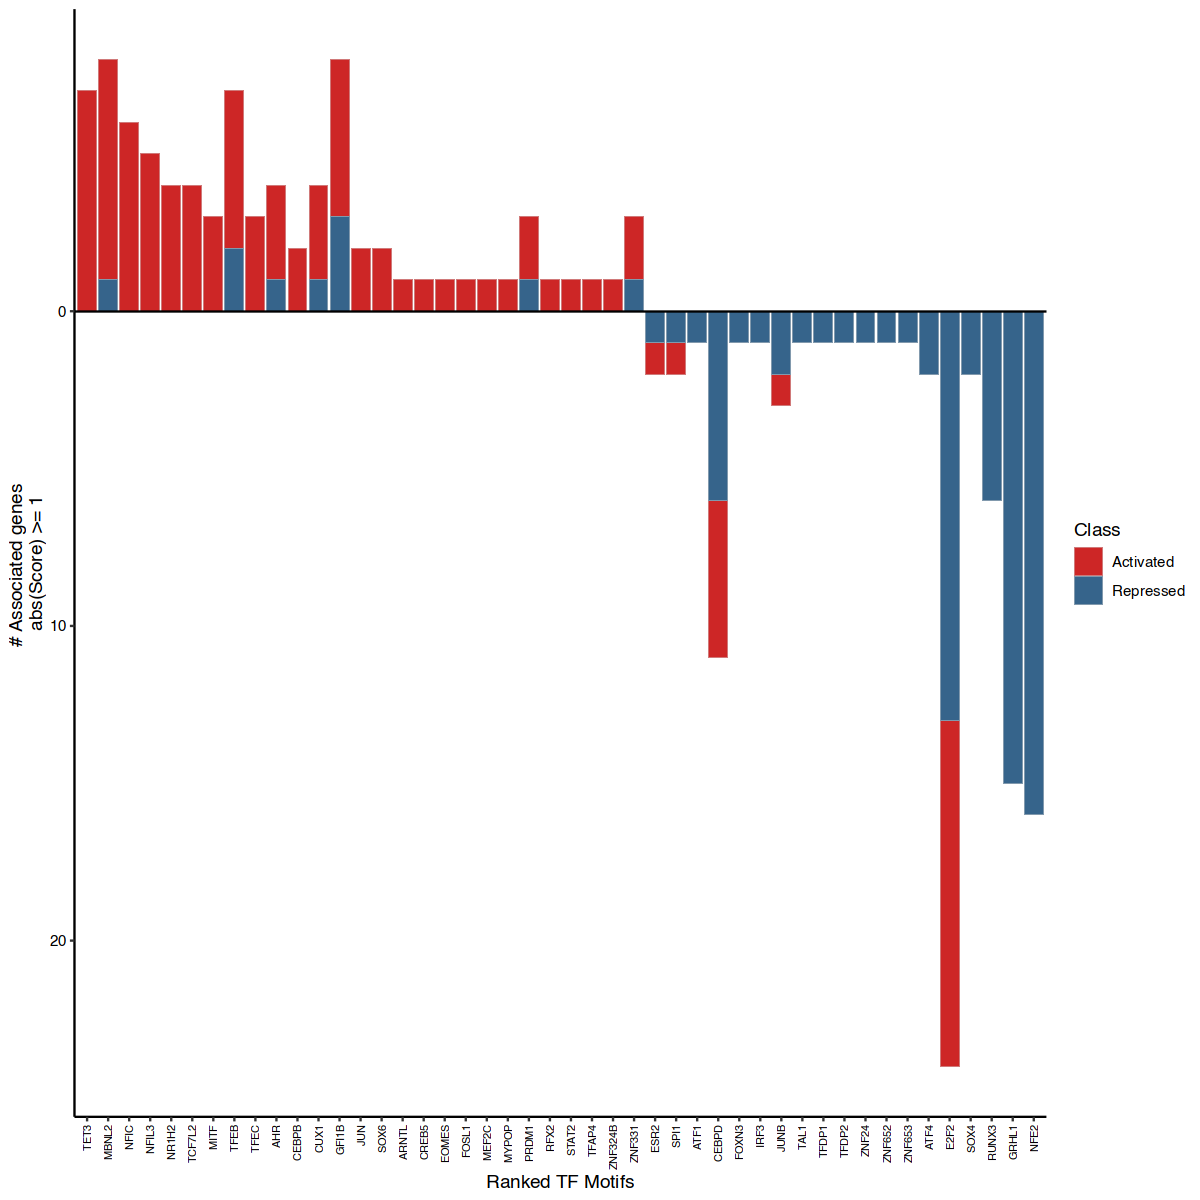

In [94]:
options(repr.plot.width=10, repr.plot.height=10)
rankDrivers(figR.d,score.cut = 1, rankBy = "nTargets", interactive = FALSE, fontsiz)

The following visualization is a heatmap-based visualization of DORC-scores for candidate TFs and strong genes they potentially regulate, based on TF-DORC-target gene associations.
(Rows = Target genes, Columns = TF).

In [68]:
library(grid)
library(ComplexHeatmap)


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern


ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




Using absolute score cut-off of: 1 ..


Using Score as value column: use value.var to override.

Plotting 45 DORCs x 46TFs




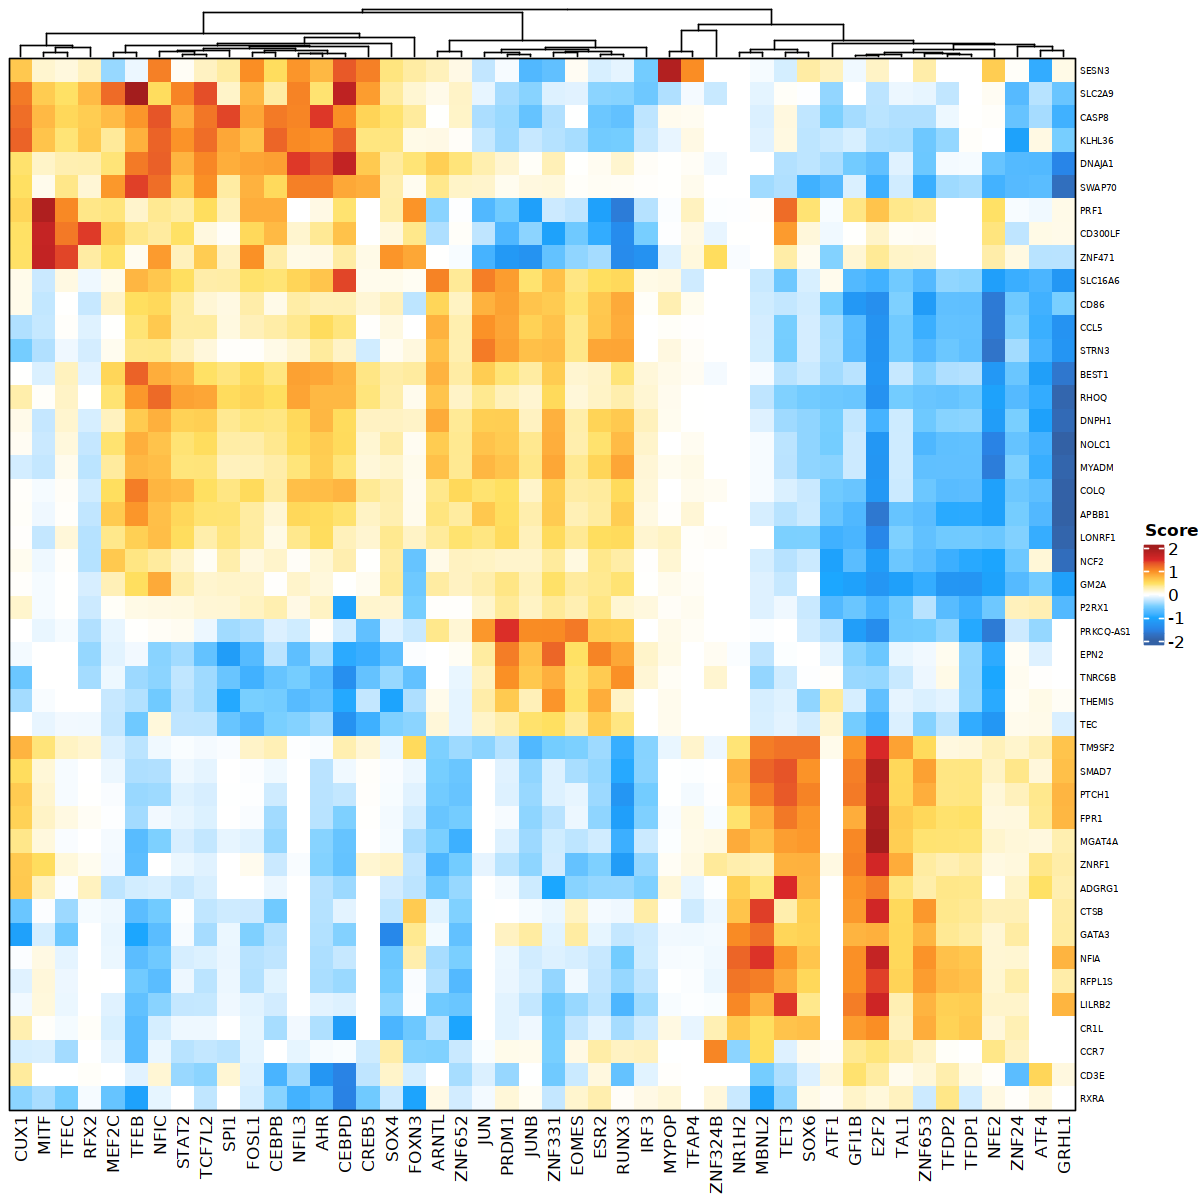

In [69]:
options(repr.plot.width=10, repr.plot.height=10)
pushViewport(viewport(gp = gpar(fontfamily = "sans")));
heatmap <- plotfigRHeatmap(figR.d = figR.d,
                           score.cut = 1,
                           TFs = unique(figR.d$Motif),
                           column_names_gp = gpar(fontsize=10), # from ComplexHeatmap
                           show_row_dend = FALSE # from ComplexHeatmap
                          )
draw(heatmap, newpage = FALSE)
popViewport()


This visualization allows us to quickly identify the main TFs and their association with the regulation of potential target genes through DORCs in their genome neighborhoods.

As a last exploratory visualization, a network of associations can also be retrieved, using the package networkD3. This allows exploring clusters of genes that are overlapping across TFs, and potentially overlapping regulons controlled by common-TFs.

In [70]:
library(networkD3)
library(r2d3)
library(imager)

Warning message:
“package ‘imager’ was built under R version 4.2.3”
Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:GenomicRanges’:

    subtract



Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following object is masked from ‘package:grid’:

    depth


The following object is masked from ‘package:BSgenome’:

    width


The following object is masked from ‘package:rtracklayer’:

    width


The following object is masked from ‘package:Biostrings’:

    width


The following object is masked from ‘package:XVector’:

    width


The following object is masked from ‘package:cowplot’:

    draw_text


The following object is masked from ‘package:dplyr’:

    where


The following objects are masked from ‘package:SummarizedExperiment’:

    resize, width


The following object is masked from ‘package:Biobase’:

    channel


The following objects are masked from ‘packa

In [71]:
# generate the network
d3 <- plotfigRNetwork(figR.d,
                      score.cut = 1,
                      TFs = unique(figR.d$Motif),
                      weight.edges = TRUE)

In [72]:
# in a local session, the network can be manipulated interactively
d3

HTML widgets cannot be represented in plain text (need html)

### Save network as HTML/PNG

In [74]:
# If pandoc if not found by R, here the bin path in the environment has to be provided e.g. `envs/best_practices_regulons_rnanatac/bin`
# rmarkdown::find_pandoc(dir = "bin_path") # e.g. bin_path = '~/miniconda3/envs/best_practices_regulons_rnanatac/bin'

# is saved as an image and shown for exploratory purposes outside of this notebook
save_d3_html(
  d3,
  'network_tutorial_rna_n_atac.html',
)

In [75]:
# the network is saved as an image and shown for online purposes.
save_d3_png(
  d3,
  'network_tutorial_rna_n_atac.png',
  width = 350,
  height = 450,
  delay = 4.0,
  zoom = 1.6,
)

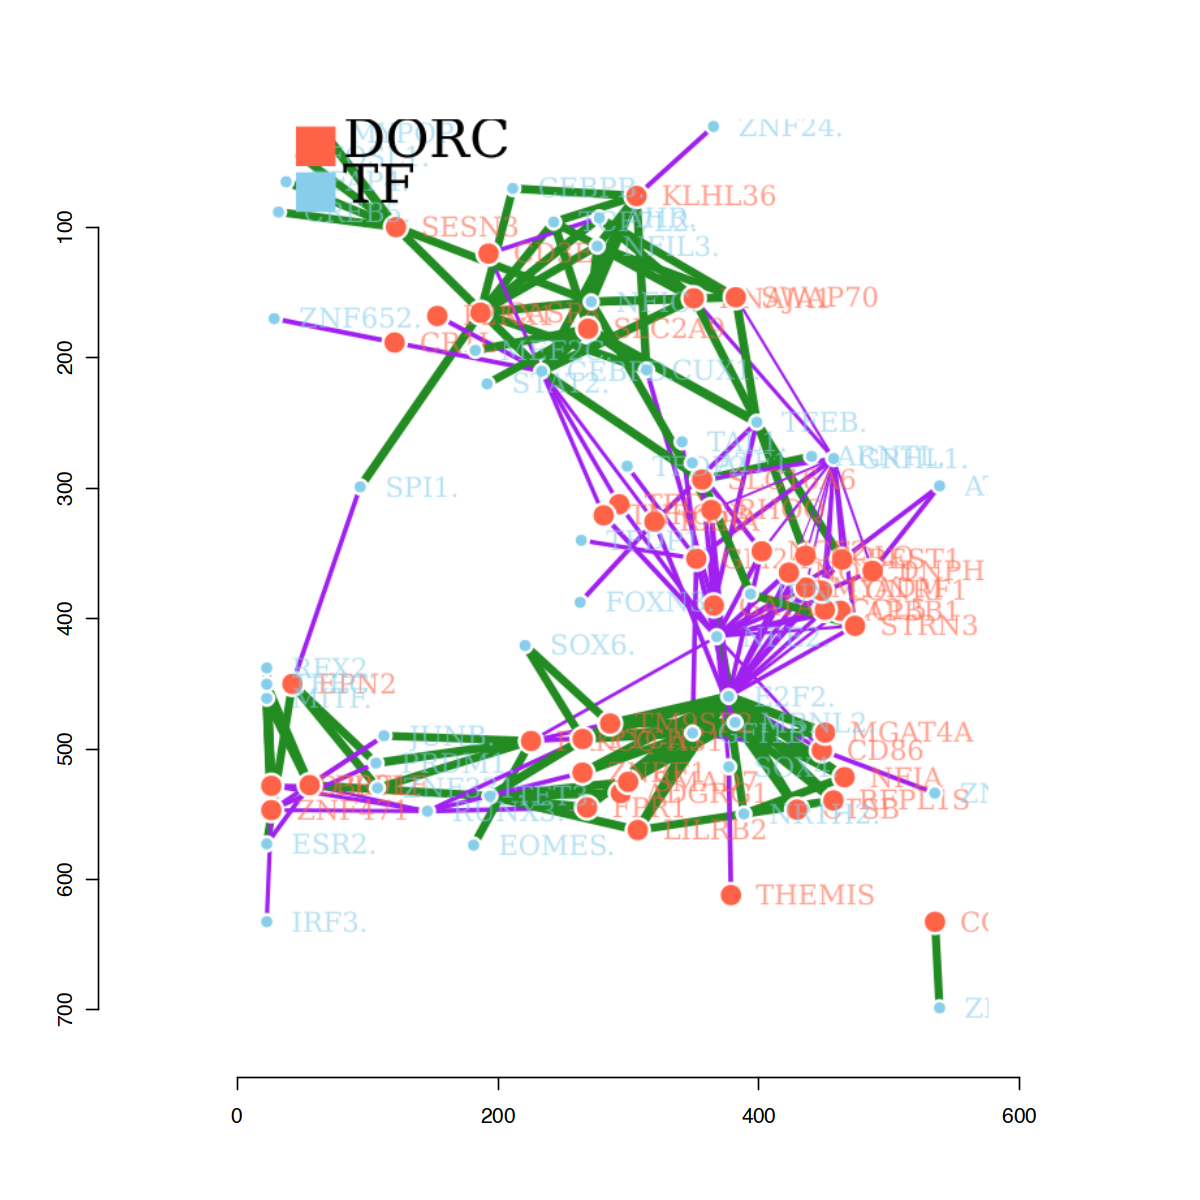

In [76]:
im <- load.image('network_tutorial_rna_n_atac.png')
plot(im)

Log of packages used to execute this notebook

In [77]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04 LTS

Matrix products: default
BLAS/LAPACK: /home/rio/miniconda3/envs/best_practices_regulons_rnanatac/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] imager_0.42.19                    magrittr_2.0.3                   
 [3] r2d3_0.2.6                        networkD3_0.4                    
 [5] ComplexHeatmap_2.14.0             BuenColors_0.5.6                 
 [7] MASS_7.3-58.3                     patchwork_1.1.2                  
 [9] ggrastr_

## Takeaways

In this notebook, we have:

1. Prepared an RNA and ATAC object using R, for processing with FigR and CisTopic.
2. Calculated DORC scores with FigR, and visualized those as scatter, heatmap and networks.

## Quiz

### Theory

1. Why are peak-to-gene associations considered mechanistically valid?
2. What are there more peaks than genes, and as consequence, multiple peaks targeting a single gene, when building GRNs?
3. What is considered a TF activator/repressor as the level of peak, and at the level of gene groups.
4. What additional readouts are complementary to scRNA-seq and scATAC-seq, when interpreting ATAC+RNA GRN models.

### FigR

1. What is the DORC score and how it could be useful to identify regulatory interactions between peaks and genes?

## References

```{bibliography}\n",
:filter: docname in docnames
:labelprefix: anno
```

## Contributors
We gratefully acknowledge the contributions of:
### Authorms
* Ignacio Ibarra
### Reviewers
* Lukas Heumos
* Anna Schaar